In [1]:
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms


In [45]:
# load minist dataset and reshape to 16x16
def load_mnist(batch_size=128, target_digit=0):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((16, 16)),
        # Removed flattening - VAE expects 4D input (B, C, H, W)
    ])
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    
    # Filter to only include the target digit
    train_indices = (train_dataset.targets == target_digit).nonzero(as_tuple=True)[0]
    test_indices = (test_dataset.targets == target_digit).nonzero(as_tuple=True)[0]
    train_dataset.data = train_dataset.data[train_indices]
    test_dataset.data = test_dataset.data[test_indices]
    train_dataset.targets = train_dataset.targets[train_indices]
    test_dataset.targets = test_dataset.targets[test_indices]   

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader




In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, latent_dim=2, in_channels=1):
        super().__init__()
        self.latent_dim = latent_dim
        self.in_channels = in_channels

        # -------- Encoder --------
        # Input: (B, C, 16, 16)
        self.enc_conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),  # 16 -> 8
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),           # 8 -> 4
            nn.ReLU(inplace=True),
        )
        # Now feature map is (B, 64, 4, 4) -> 64*4*4 = 1024
        self.enc_fc = nn.Linear(64 * 4 * 4, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # -------- Decoder --------
        self.dec_fc = nn.Linear(latent_dim, 128)
        self.dec_fc2 = nn.Linear(128, 64 * 4 * 4)
        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 4 -> 8
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),  # 8 -> 16
            nn.Sigmoid()  # output in [0,1]
        )

    # ---- Encoder step: x -> μ, logσ² ----
    def encode(self, x):
        h = self.enc_conv(x)               # (B, 64, 4, 4)
        h = h.view(x.size(0), -1)          # (B, 1024)
        h = F.relu(self.enc_fc(h))         # (B, 128)
        mu = self.fc_mu(h)                 # (B, latent_dim)
        logvar = self.fc_logvar(h)         # (B, latent_dim)
        return mu, logvar

    # ---- Reparameterization: μ, logσ² -> z ----
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    # ---- Decoder step: z -> x̂ ----
    def decode(self, z):
        h = F.relu(self.dec_fc(z))         # (B, 128)
        h = F.relu(self.dec_fc2(h))        # (B, 64*4*4)
        h = h.view(z.size(0), 64, 4, 4)    # (B, 64, 4, 4)
        x_hat = self.dec_deconv(h)         # (B, C, 16, 16)
        return x_hat

    # ---- Full forward: x -> x̂, μ, logσ² ----
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [35]:
def vae_loss(recon_x, x, mu, logvar):
    # Flatten both tensors for BCE computation
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)
    
    # reconstruction loss (BCE for images in [0, 1])
    recon_loss = F.binary_cross_entropy(
        recon_x_flat, x_flat, reduction="sum"
    ) / x.size(0)

    # KL divergence between q(z|x) = N(mu, sigma^2)
    # and p(z) = N(0, I)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    return recon_loss + kld, recon_loss, kld

In [46]:
# train the VAE
def train_vae(model, train_loader, num_epochs=50, learning_rate=1e-3, device='cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kld = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')
    return model
vae_models=[]

for digit in range(10):
    print(f"Training VAE for digit: {digit}")
    train_loader, test_loader = load_mnist(target_digit=digit)
    vae_model = VAE(latent_dim=2, in_channels=1)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    vae_model = train_vae(vae_model, train_loader, num_epochs=5, learning_rate=1e-3, device=device)
    vae_models.append(vae_model)

Training VAE for digit: 0
Using device: cuda
Epoch [1/5], Loss: 96.1505
Epoch [1/5], Loss: 96.1505
Epoch [2/5], Loss: 71.5109
Epoch [2/5], Loss: 71.5109
Epoch [3/5], Loss: 67.3902
Epoch [3/5], Loss: 67.3902
Epoch [4/5], Loss: 66.5673
Epoch [4/5], Loss: 66.5673
Epoch [5/5], Loss: 66.1684
Training VAE for digit: 1
Using device: cuda
Epoch [5/5], Loss: 66.1684
Training VAE for digit: 1
Using device: cuda
Epoch [1/5], Loss: 70.8417
Epoch [1/5], Loss: 70.8417
Epoch [2/5], Loss: 36.0394
Epoch [2/5], Loss: 36.0394
Epoch [3/5], Loss: 31.8666
Epoch [3/5], Loss: 31.8666
Epoch [4/5], Loss: 29.4730
Epoch [4/5], Loss: 29.4730
Epoch [5/5], Loss: 28.9839
Training VAE for digit: 2
Using device: cuda
Epoch [5/5], Loss: 28.9839
Training VAE for digit: 2
Using device: cuda
Epoch [1/5], Loss: 103.8175
Epoch [1/5], Loss: 103.8175
Epoch [2/5], Loss: 70.8657
Epoch [2/5], Loss: 70.8657
Epoch [3/5], Loss: 69.8686
Epoch [3/5], Loss: 69.8686
Epoch [4/5], Loss: 69.6943
Epoch [4/5], Loss: 69.6943
Epoch [5/5], Loss

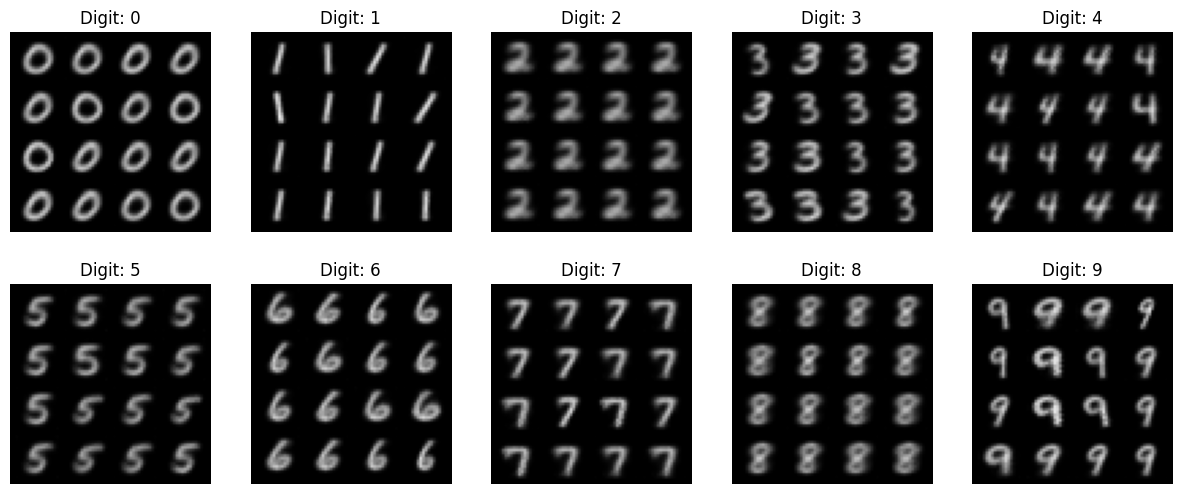

In [51]:
# generate samples

import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,5,figsize=(15,6))
for digit, vae_model in enumerate(vae_models):
    vae_model.eval()
    with torch.no_grad():
        z = torch.randn(16, vae_model.latent_dim).to(device)
        samples = vae_model.decode(z).cpu()
    torchvision.utils.make_grid(samples, nrow=4)
    ax[digit//5,digit%5].imshow(torchvision.utils.make_grid(samples, nrow=4).permute(1,2,0))
    ax[digit//5,digit%5].set_title(f"Digit: {digit}")
    ax[digit//5,digit%5].axis('off')

In [53]:
# save the models

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
save_dir = os.path.join(project_root, 'saved_models')
os.makedirs(save_dir, exist_ok=True)

for digit, vae_model in enumerate(vae_models):
    model_path = os.path.join(save_dir, f'vae_mnist_digit_{digit}.pth')
    torch.save(vae_model.state_dict(), model_path)
    print(f"Saved VAE model for digit {digit} at {model_path}")

Saved VAE model for digit 0 at e:\Thieses mit Thies\uamocf\saved_models\vae_mnist_digit_0.pth
Saved VAE model for digit 1 at e:\Thieses mit Thies\uamocf\saved_models\vae_mnist_digit_1.pth
Saved VAE model for digit 2 at e:\Thieses mit Thies\uamocf\saved_models\vae_mnist_digit_2.pth
Saved VAE model for digit 3 at e:\Thieses mit Thies\uamocf\saved_models\vae_mnist_digit_3.pth
Saved VAE model for digit 4 at e:\Thieses mit Thies\uamocf\saved_models\vae_mnist_digit_4.pth
Saved VAE model for digit 5 at e:\Thieses mit Thies\uamocf\saved_models\vae_mnist_digit_5.pth
Saved VAE model for digit 6 at e:\Thieses mit Thies\uamocf\saved_models\vae_mnist_digit_6.pth
Saved VAE model for digit 7 at e:\Thieses mit Thies\uamocf\saved_models\vae_mnist_digit_7.pth
Saved VAE model for digit 8 at e:\Thieses mit Thies\uamocf\saved_models\vae_mnist_digit_8.pth
Saved VAE model for digit 9 at e:\Thieses mit Thies\uamocf\saved_models\vae_mnist_digit_9.pth


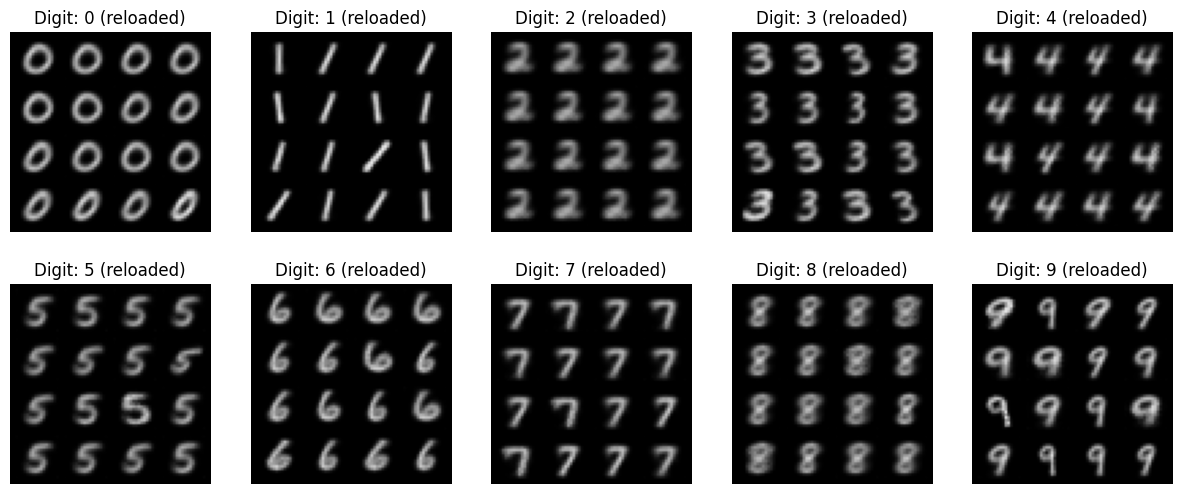

In [54]:
# try reload and generate samples again
vae_models_reload=[]
for digit in range(10):
    vae_model = VAE(latent_dim=2, in_channels=1)
    model_path = os.path.join(save_dir, f'vae_mnist_digit_{digit}.pth')
    vae_model.load_state_dict(torch.load(model_path, map_location=device))
    vae_model.to(device)
    vae_models_reload.append(vae_model)

# generate samples from reloaded models
fig,ax = plt.subplots(2,5,figsize=(15,6))
for digit, vae_model in enumerate(vae_models_reload):
    vae_model.eval()
    with torch.no_grad():
        z = torch.randn(16, vae_model.latent_dim).to(device)
        samples = vae_model.decode(z).cpu()
    torchvision.utils.make_grid(samples, nrow=4)
    ax[digit//5,digit%5].imshow(torchvision.utils.make_grid(samples, nrow=4).permute(1,2,0))
    ax[digit//5,digit%5].set_title(f"Digit: {digit} (reloaded)")
    ax[digit//5,digit%5].axis('off')

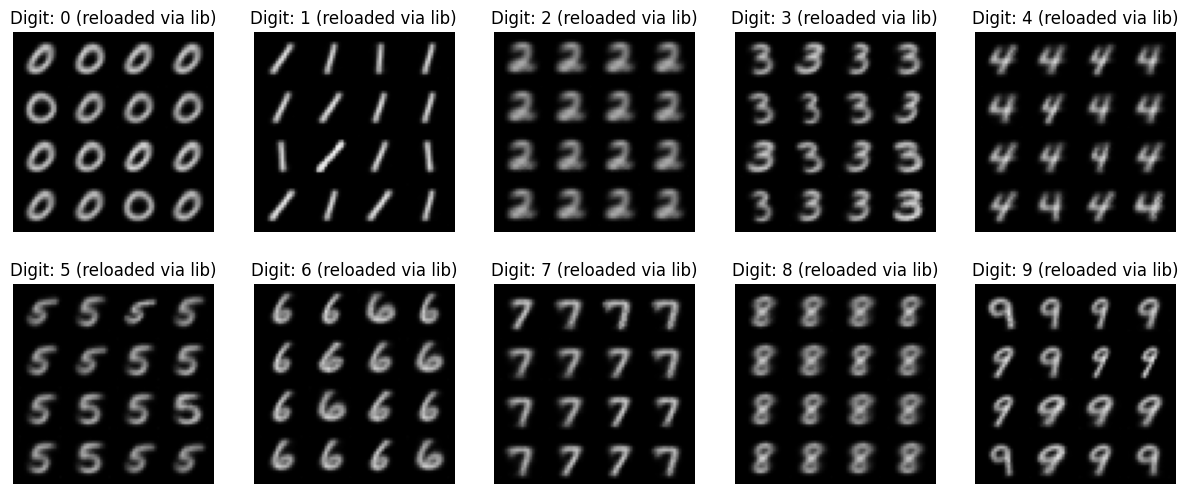

In [11]:
# try reload and generate samples again use our lib
import os,sys
import torch
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
from importlib import reload
import core.models
reload(core.models)
from core.models import VAE, reload_vae_model
import torchvision

models_reloaded = reload_vae_model(device=device)

# generate samples from reloaded models
fig,ax = plt.subplots(2,5,figsize=(15,6))
for digit, vae_model in enumerate(models_reloaded):
    vae_model.eval()
    with torch.no_grad():
        z = torch.randn(16, vae_model.latent_dim).to(device)
        samples = vae_model.decode(z).cpu()
    torchvision.utils.make_grid(samples, nrow=4)
    ax[digit//5,digit%5].imshow(torchvision.utils.make_grid(samples, nrow=4).permute(1,2,0))
    ax[digit//5,digit%5].set_title(f"Digit: {digit} (reloaded via lib)")
    ax[digit//5,digit%5].axis('off')